In [1]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pdb import set_trace as breakpoint
from time import time
from angler import Simulation

import numpy as np
import matplotlib.pyplot as plt
import h5py

from neural_maxwell.datasets.generators1d import * 
from neural_maxwell.datasets.permittivity_datasets import PermittivityDataset
from neural_maxwell.models.unsupervised_1d import MaxwellDense, MaxwellConvolutionalMiniNet
from neural_maxwell.constants import *
from neural_maxwell.utils import pbar, tensor_diff, tensor_roll

## Cavity experiments

In [2]:
# perms = np.ones(65)
perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

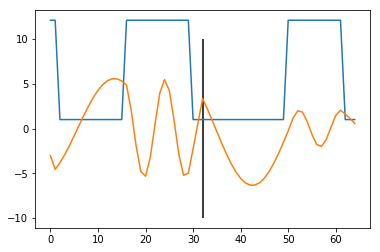

In [3]:
plt.plot(epsilons[16:-16])
plt.plot(np.real(Ez)[16:-16], label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()


In [4]:
a = torch.tensor(np.real(Ez)[16:-16])
roll=tensor_roll(a, 1)
dif = tensor_diff(a, n=2, cyclic=True)

zero = torch.tensor([0.0]).double()
# dif2 = torch.cat([zero,tensor_diff(a, n=2, padding=None), zero],dim=-1)
dif2=tensor_diff(a, n=2, padding=True)

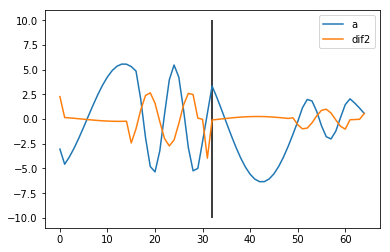

In [5]:
plt.plot(a.numpy(), label='a')
# plt.plot(roll.numpy(), label='roll')
# plt.plot(dif.numpy(), label='dif')
plt.plot(dif2.numpy(), label='dif2')
plt.vlines(src_x, -10, 10)
plt.legend()
plt.show()

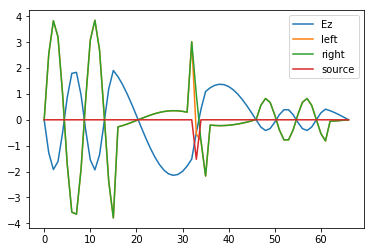

In [6]:
# sourcevals = []
# for i in pbar(range(1000)):

perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

a = torch.cat([zero, torch.tensor(np.real(Ez)[16:-16]), zero], dim=-1)
diffs = torch.cat([zero, tensor_diff(a, n=2, padding=None), zero], dim=-1)
# diffs = tensor_diff(a, n=2, cyclic=True)

ez = np.concatenate([[0], np.real(Ez[16:-16]), [0]])

eps = epsilons[16:-16]
barrier = torch.tensor([-1e10]).double()
eps = torch.cat([barrier, torch.tensor(eps), barrier], dim=-1)

# print(a.shape, dif2.shape, ez.shape, eps.shape)

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs.numpy() / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps.numpy() * ez
source = left-right

plt.plot(0.1 * ez, label="Ez")
plt.plot(left, label="left")
plt.plot(right, label="right")

plt.plot(source, label="source")
plt.legend()
plt.show()

# sourcemax = np.max(source[1:-1])
# sourcevals.append(sourcemax)
    

## Models

In [2]:
class MaxwellConvV2(nn.Module):
    
    def __init__(self, size=64, src_x=32, drop_p=0.1):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.cavity_buffer=4
        self.total_size = self.size + 2 * self.cavity_buffer
        self.drop_p=drop_p

        c1, c2, c3 = 32, 64, 128
        k1, k2, k3 = 5, 7, 9
        
        self.convnet = nn.Sequential(
            nn.Conv1d(1, c1, kernel_size=k1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c1, c2, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c2, c3, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p)
        )
        out_size = size - (k1-1) - (k2-1) - (k3-1)
        
        self.densenet = nn.Sequential(
            nn.Linear(out_size * c3, out_size * c3),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Linear(out_size * c3, out_size * c3),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
        )

        self.invconvnet = nn.Sequential(
            nn.ConvTranspose1d(c3, c2, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.ConvTranspose1d(c2, c1, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(c1, 1, kernel_size=k1, stride=1, padding=0),
        )
        
        curl_op, eps_op = Cavity1D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor(np.asarray(np.real(curl_op)), device=device).float()  
    
    def get_fields(self, epsilons):
        batch_size, L = epsilons.shape
        out = epsilons.view(batch_size, 1, L)
        
        out = self.convnet(out)
        _, c, l2 = out.shape
        
        out = out.view(batch_size, -1)
        out = self.densenet(out)
        
        out = out.view(batch_size, c, l2)
        out = self.invconvnet(out)
        
        out = out.view(batch_size, L)
        
        return out
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        batch_size, _ = epsilons.shape

        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(fields, [self.cavity_buffer]*2)
        E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
        eps = F.pad(epsilons, [self.cavity_buffer]*2, "constant", -1e20)
        eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
        curl_curl_E = (SCALE / L0**2) * torch.matmul(self.curl_curl_op, E).view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        # Compute free-current vector
        J = torch.zeros(batch_size, self.total_size, 1, device=device)
        J[:, self.src_x + self.cavity_buffer, 0] = -1.526814027933079 

        out = curl_curl_E - epsilon_E - J

        return out[:, self.cavity_buffer:-self.cavity_buffer]     

In [3]:
class MaxwellConvComplex(nn.Module):
    
    def __init__(self, size=64, src_x=None, buffer=16, npml=16, drop_p=0.1, polar=False):
        super().__init__()
        
        self.size = size
        self.buffer = buffer
        self.npml = npml
        self.src_x = src_x if src_x is not None else self.npml + self.buffer
        self.total_size = self.npml + 2 * self.buffer + self.size + self.npml
        self.drop_p = drop_p
        self.polar = polar

        c1, c2, c3 = 32, 64, 128
        k1, k2, k3 = 3, 5, 7
        
        self.convnet = nn.Sequential(
            nn.Conv1d(1, c1, kernel_size=k1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c1, c2, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c2, c3, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p)
        )
        out_size = self.total_size - (k1-1) - (k2-1) - (k3-1)
        
        self.densenet = nn.Sequential(
            nn.Linear(out_size * c3, out_size * c3),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
#             nn.Linear(out_size * c3, out_size * c3),
#             nn.ReLU(),
#             nn.Dropout(p=self.drop_p),
        )

        self.invconvnet = nn.Sequential(
            nn.ConvTranspose1d(c3, c2, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.ConvTranspose1d(c2, c1, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(c1, 2, kernel_size=k1, stride=1, padding=0),
        )
        
        curl_op, _ = get_A_ops_1d(np.ones(self.total_size), self.npml)
        self.curl_curl_re = torch.tensor(np.asarray(np.real(curl_op)), device=device).float()  
        self.curl_curl_im = torch.tensor(np.asarray(np.imag(curl_op)), device=device).float()  

    
    def forward_fields(self, epsilons):
        batch_size, L = epsilons.shape
        out = epsilons.view(batch_size, 1, L)
        
        out = self.convnet(out)
        
        _, c, l2 = out.shape
        out = out.view(batch_size, -1)
        out = self.densenet(out)
        out = out.view(batch_size, c, l2)
        
        out = self.invconvnet(out)
        
        out = out.view(batch_size, 2, L)
        
        return out
    
    def get_fields(self, epsilons):
        # Compute Ez fields
        fields = self.forward_fields(epsilons)

        # Separate into real and imaginary parts
        if not self.polar:
            E_re = fields[:, 0]
            E_im = fields[:, 1]
        else:
            E_abs = fields[:, 0]
            E_phi = fields[:, 1]
            E_re = E_abs * torch.cos(E_phi)
            E_im = E_abs * torch.sin(E_phi)
            
        return E_re, E_im
    
    def forward(self, epsilons):
        
        batch_size, _ = epsilons.shape
        
        E_re, E_im = self.get_fields(epsilons)
            
        # Broadcast E and epsilon vectors for matrix multiplication
        E_re = E_re.view(batch_size, -1, 1)
        E_im = E_im.view(batch_size, -1, 1)
        eps = epsilons.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
        curl_curl_E_re = (SCALE / L0**2) * (torch.matmul(self.curl_curl_re, E_re) 
                                            - torch.matmul(self.curl_curl_im, E_im))
        curl_curl_E_im = (SCALE / L0**2) * (torch.matmul(self.curl_curl_im, E_re) 
                                            + torch.matmul(self.curl_curl_re, E_im))

        epsilon_E_re = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E_re
        epsilon_E_im = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E_im

        # Compute free-current vector
        J_re = torch.zeros(batch_size, self.total_size, 1, device=device)
        J_im = torch.zeros(batch_size, self.total_size, 1, device=device)
        J_re[:, self.src_x, 0] = -1.526814027933079 # source is in phase with real part

        out_re = curl_curl_E_re - epsilon_E_re - J_re
        out_im = curl_curl_E_im - epsilon_E_im - J_im
        
        CONCAT = True
        if CONCAT: 
            # output is concatenated real and imaginary part
            out = torch.cat((out_re, out_im), dim=-1)
        else:
            # output is sum of real and imaginary part
            out = torch.abs(out_re) + torch.abs(out_im)

        return out

## Training

In [4]:
def epsilon_generator(s=64, npml=16, buffer=0):
    perms = perm_random_number_alternating_layers(s=s)
    epsilons = np.ones(s + 2*npml + 2*buffer)
    epsilons[npml+buffer:-(npml+buffer)] = perms
    return epsilons

In [5]:
# Hyperparameters
num_epochs = 300
learning_rate = 5e-6
# batch_size = 512
batch_size = 200


# Device configuration
device = torch.device('cuda:0')
# device = torch.device('cpu')

# Create a model   
# model = MaxwellDense(supervised=False, regularize_A_phi=False).to(device)
# model = MaxwellConvolutionalMiniNet().to(device)
model = MaxwellConvV2(drop_p=0.0).to(device)
# model = MaxwellConvComplex(src_x = 64//2 + 16, buffer=0, drop_p=0.0, polar=False).to(device)

# Create data loaders
train_data = PermittivityDataset(perm_random_number_alternating_layers, N=1e6, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
test_data = PermittivityDataset(perm_random_number_alternating_layers, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for epsilons in train_loader:
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), '../models/checkpoints/model1d.ckpt')

KeyboardInterrupt: 

In [6]:
# torch.save(model.state_dict(), '../models/checkpoints/model1d_complex.ckpt')
# torch.save(model.state_dict(), '../models/checkpoints/model1d_dec6_nodropout.ckpt')
model.load_state_dict(torch.load('../models/checkpoints/model1d_dec6_nodropout.ckpt'))

In [98]:
test_loader = DataLoader(dataset=test_data, batch_size=1000, shuffle=False)

In [100]:
# Compute loss on test set

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
test_losses = []

with torch.no_grad():
    start = time()
    for epsilons in pbar(test_loader):
        epsilons = epsilons.float().to(device)
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        test_losses.append(loss)

print(f"Mean loss: {np.mean(np.array(test_losses))}, time: {time()-start}")

Mean loss: 0.0008808978600427508, time: 0.1389169692993164


In [ ]:
# model.load_state_dict(torch.load("model1d_nov30_3.ckpt"))

In [14]:
def plot_model_outputs(perms):
    start = time()
    _, src_x, Hx, Hy, Ez = Cavity1D(device_length=64, cavity_buffer=16).solve(perms, omega=OMEGA_1550)
    sim_time = time() - start
    
    Ez_true = np.real(Ez)[16:-16]

    epsilons = torch.tensor([perms], device=device).float()
    start = time()
    fields = model.get_fields(epsilons)
    network_time = time() - start
    
    Ez_pred = fields[0].detach().cpu().numpy()
    scale_ratio = np.mean(np.abs(Ez_true)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio
    
    outputs = model(epsilons)
    
    loss = criterion(outputs, torch.zeros_like(outputs))
    outputs = outputs[0].detach().cpu().numpy() 
    
    print(f"Error: {np.linalg.norm(outputs)}")
    print(f"Loss: {loss.item()}")

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))

    # Make initial figure
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(18,12), gridspec_kw = {'height_ratios':[3, 1]})
    fig.subplots_adjust(hspace=0)
    for a in ax:
        a.label_outer()

    x = PIXEL_SIZE / 1e-6 * (np.arange(len(Ez_true)) - src_x)
    ax[0].plot(x, perms, label="$\epsilon (x)$", c='grey')
    ax[0].plot(x, np.zeros(outputs.shape), linestyle=':', c='grey')
    ax[0].fill_between(x, perms, alpha=0.1, color='grey')
    ax[0].plot(x, Ez_true, label="$E_\mathrm{true}$", c='C0')
    Ez_pred_line = ax[0].plot(x, Ez_pred, label="$E_\mathrm{pred}$", c='C1')
#     ax[0].set_ylim(-15, 15)
    ax[0].legend(loc="lower right")

    outputs_line = ax[1].plot(x, outputs, label="$\\nabla \\times \\nabla \\times E - \omega^2 \mu_0 \epsilon E - J$", c='red')
    ax[1].fill_between(x, outputs.flatten(), alpha=0.05, color='red')
    ax[1].plot(x, np.zeros(outputs.shape), linestyle=':', c='grey')
    ax[1].set_ylim(-.25, .25)
    ax[1].set_xlabel("$x (\mu m)$")
    ax[1].text(0.05, 0.85, '$\mathcal{{L}}=${:.1e}'.format(loss.item()), fontsize='xx-large', transform=ax[1].transAxes)
    ax[1].legend(loc="upper right")

    plt.show()

In [15]:
def plot_model_outputs_complex(perms, npml=16, buffer=16, src_x=None):
    start = time()
    sim = Simulation(OMEGA_1550, perms, 0.05, [npml, 0], "Ez")
    if src_x is None:
        src_x = npml + buffer
    sim.src[src_x] = 1j
    Hx, Hy, Ez = sim.solve_fields()
    sim_time = time() - start
    
    Ez_re_true = np.real(Ez)
    Ez_im_true = np.imag(Ez)

    epsilons = torch.tensor([perms], device=device).float()
    start = time()
    Ez_re_pred, Ez_im_pred = model.get_fields(epsilons)
    network_time = time() - start
    
    Ez_re_pred = Ez_re_pred.detach().cpu().numpy().flatten()
    Ez_im_pred = Ez_im_pred.detach().cpu().numpy().flatten()
    scale_ratio = np.mean(np.abs(Ez_re_true) + np.abs(Ez_im_true)) / \
                  np.mean(np.abs(Ez_re_pred) + np.abs(Ez_im_pred))
#     Ez_re_pred *= scale_ratio
#     Ez_im_pred *= scale_ratio
    
    outputs = model(epsilons)
    loss = criterion(outputs, torch.zeros_like(outputs))
    outputs = outputs[0].detach().cpu().numpy() 
    outputs_re = outputs[:,0]
    outputs_im = outputs[:,1]
    
    print(f"Error: {np.linalg.norm(outputs)}")
    print(f"Loss: {loss.item()}")

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))

    f, ax = plt.subplots(2, 1, figsize=(12,12))
    ax[0].plot(perms, label="$\epsilon(x)$")
    ax[0].plot(Ez_re_pred, label="$\Re E_\mathrm{pred}$")
    ax[0].plot(Ez_re_true, label="$\Re E_\mathrm{true}$")
    ax[0].plot(-10 + 20*outputs_re, label="Model output")
    ax[0].plot(-10 * np.ones(outputs_re.shape), linestyle=':')
    ax[0].vlines(src_x, -10, 10)
    ax[0].legend()
    
    ax[1].plot(perms, label="$\epsilon(x)$")
    ax[1].plot(Ez_im_pred, label="$\Im E_\mathrm{pred}$")
    ax[1].plot(Ez_im_true, label="$\Im E_\mathrm{true}$")
    ax[1].plot(-10 + 20*outputs_im, label="Model output")
    ax[1].plot(-10 * np.ones(outputs_im.shape), linestyle=':')
    ax[1].vlines(src_x, -10, 10)
    ax[1].legend()

    plt.show()

Error: 0.42961814999580383
Loss: 0.0028839334845542908
Sim time: 0.01111 | Network time: 0.00154 | Ratio: 0.13829


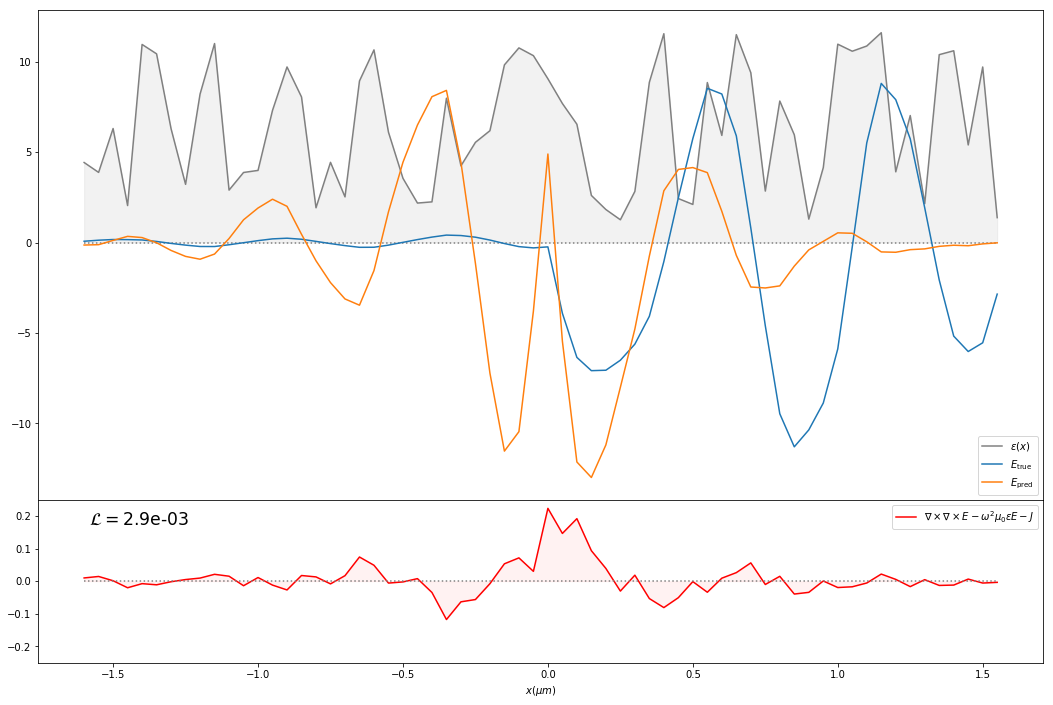

In [101]:
model.eval()
    
# perms = perm_random_number_alternating_layers()
# perms = perm_alternating_layers(num_layers=12, eps1=eps_si, eps2=eps_sio2)
perms = perm_random()
# perms = epsilon_generator()

plot_model_outputs(perms)
# plot_model_outputs_complex(perms, buffer=0, src_x=64//2+16)

Error: 0.27552831172943115
Loss: 0.0002791023871395737
Sim time: 0.00982 | Network time: 0.00170 | Ratio: 0.17327


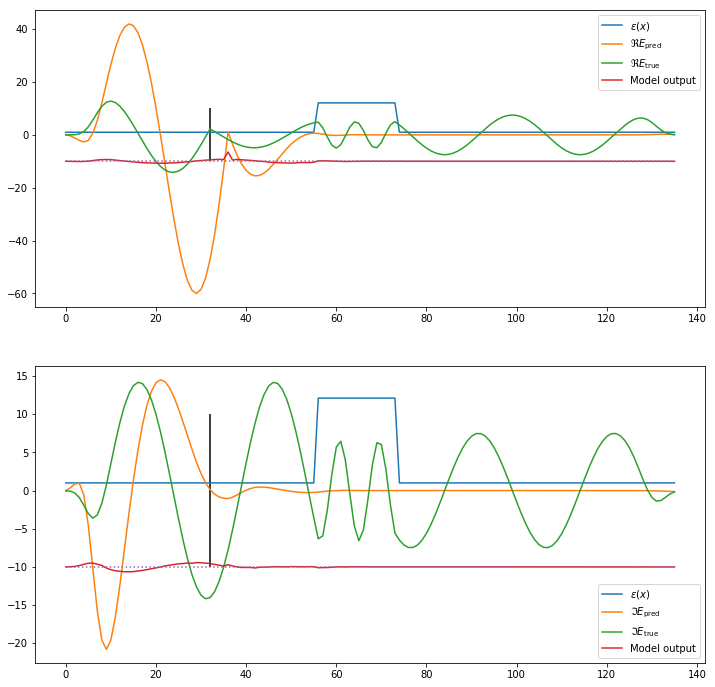

In [100]:
model.eval()
    
# perms = perm_random_number_alternating_layers()
perms = epsilon_generator()

# plot_model_outputs(perms)
plot_model_outputs_complex(perms)

In [23]:
all_perms = []
for i in pbar(range(10000)):
    perms = perm_random_number_alternating_layers()
    epsilons = torch.tensor([perms], device=device).float()
    outputs = model(epsilons)
    loss = criterion(outputs, torch.zeros_like(outputs)).item()
    all_perms.append((loss, perms))
all_perms.sort(key=lambda x:x[0])

0


Error: 0.042122479528188705
Loss: 2.7723492166842334e-05
Sim time: 0.01098 | Network time: 0.00171 | Ratio: 0.15574


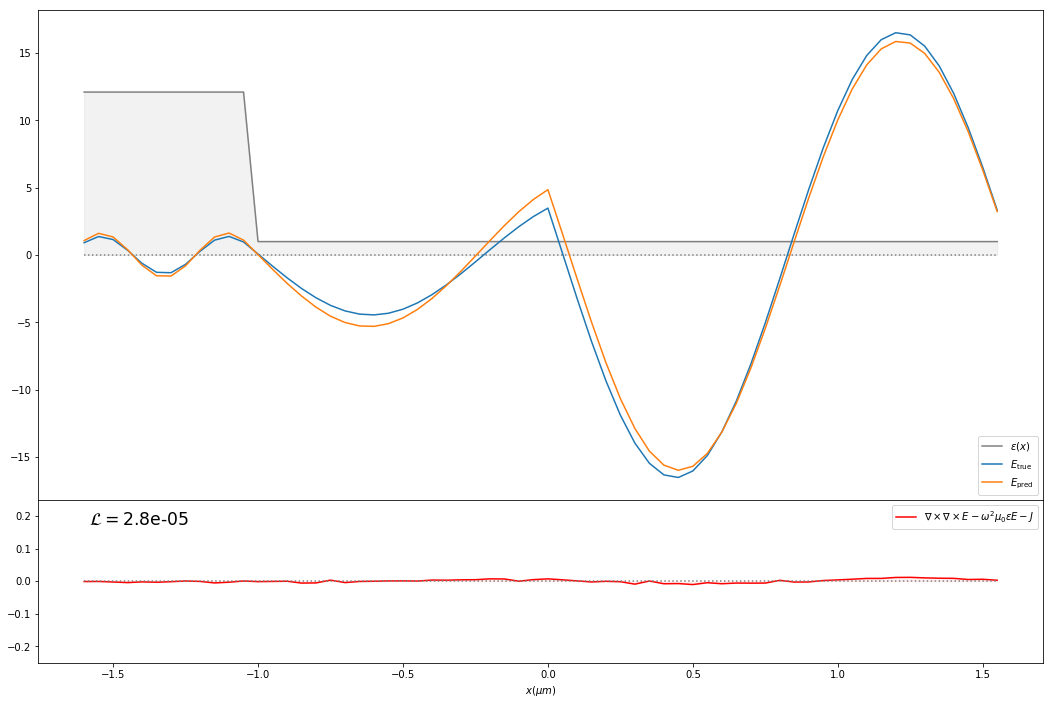

In [57]:
start = 0
end = 100
for i in range(start, end, 100):
    print(f"{i}\n\n")
    plot_model_outputs(all_perms[i][1])